In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
from scipy.special import erfc

# Functions

In [30]:
def initialize_diffusion(N, dt, D=1.0):
    """
    We consider the 2D diffusion equation
        c_t = D (c_xx + c_yy)
    on 0 <= x <= 1, 0 <= y <= 1, with Delta x = Delta y = 1/N.

    The boundary conditions are
        c(x,0,t)=0,  c(x,1,t)=1,
    and periodicity in the x-direction,
        c(0,y,t)=c(1,y,t).

    The initial condition is
        c(x,y,0)=0.

    In the implementation, we denote c(x_i, y_j, t^k) by C[j,i].
    """
    dx = 1.0 / N
    x = np.linspace(0.0, 1.0, N + 1)  # x_i
    y = np.linspace(0.0, 1.0, N + 1)  # y_j

    mu = D * dt / dx**2

    # Stability condition for the explicit scheme
    if 4.0 * mu > 1.0:
        raise ValueError(f"Stability violated: 4*mu = {4*mu:.3f} > 1")

    # Initial condition: c(x,y,0)=0
    C0 = np.zeros((N + 1, N + 1), dtype=float)

    # Impose the Dirichlet boundary conditions in the y-direction at t=0
    y_BC(C0)

    return x, y, dx, mu, C0


def y_BC(C):
    """
    Dirichlet boundary conditions in the y-direction:
        c(x,0,t)=0 and c(x,1,t)=1.

    In the implementation (C[j,i]):
        C[0, :]  = 0,
        C[-1, :] = 1.
    """
    C[0, :] = 0.0
    C[-1, :] = 1.0


def time_step(C, mu):
    """
    We use the explicit five-point scheme:
        c_{i,j}^{k+1} = c_{i,j}^k + mu( c_{i+1,j}^k + c_{i-1,j}^k
                                      + c_{i,j+1}^k + c_{i,j-1}^k - 4c_{i,j}^k ),
    where mu = D*dt/dx^2 and dx = dy.

    Periodicity in the x-direction is implemented by index wrapping.
    The Dirichlet boundary conditions in the y-direction are enforced after each step.
    """
    C_new = C.copy()

    # Periodic neighbours in x-direction (columns)
    C_ip1 = np.roll(C, -1, axis=1)  # i+1
    C_im1 = np.roll(C,  1, axis=1)  # i-1

    # Neighbours in y-direction (rows); interior is j = 1,...,N-1
    C_jp1 = C[2:, :]    # j+1
    C_jm1 = C[:-2, :]   # j-1

    # Update only the interior points in the y-direction; x-direction is handled by periodicity
    C_new[1:-1, :] = (
        C[1:-1, :]
        + mu * (C_ip1[1:-1, :] + C_im1[1:-1, :] + C_jp1 + C_jm1 - 4.0 * C[1:-1, :])
    )

    # Enforce the Dirichlet boundary conditions
    y_BC(C_new)

    return C_new


def time_evolution(N, dt, t_max, D=1.0, store_times=None):
    """
    This function runs the explicit scheme from t=0 to t_max with step size dt.
    If store_times is provided, the solution is stored at these times.

    Returns:
        x, y, mu, solution, nt,
    where solution is a dictionary that stores C at selected time steps.
    """
    x, y, dx, mu, C = initialize_diffusion(N, dt, D)

    nt = int(np.round(t_max / dt))
    if store_times is None:
        store_times = []

    store_idx = {int(np.round(t / dt)): t for t in store_times}
    solution = {0: C.copy()}

    for n in range(1, nt + 1):
        C = time_step(C, mu)
        if n in store_idx:
            solution[n] = C.copy()

    return x, y, mu, solution, nt


def analytical_solution_y(y, t, D, max_terms=50):
    """
    This function computes the analytical solution in the y-direction for
        c_t = D c_yy,
    with boundary conditions c(0,t)=0, c(1,t)=1 and initial condition c(y,0)=0.

    The series is truncated at max_terms.
    """
    if t <= 0.0:
        return np.zeros_like(y)

    s = np.zeros_like(y, dtype=float)
    for m in range(max_terms):
        term1 = erfc((1 - y + 2*m) / (2*np.sqrt(D*t)))
        term2 = erfc((1 + y + 2*m) / (2*np.sqrt(D*t)))
        s += term1 - term2
    return s


def plot_figure_1d(y, C, x_index, title, output_file, show=True):
    """
    This function plots c(x_fixed, y, t) for a fixed x-index and saves the figure.
    """
    fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
    ax.plot(y, C[:, x_index])
    ax.set_xlabel("y")
    ax.set_ylabel("c")
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(output_file, dpi=200)
    if show:
        plt.show()
    plt.close(fig)


def plot_figure_2d(C, title, output_file, show=True):
    """
    This function plots c(x,y,t) on the 2D domain and saves the figure.
    """
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
    im = ax.imshow(
        C,
        origin="lower",
        extent=[0, 1, 0, 1],
        aspect="auto",
        cmap="plasma",
        vmin=0,
        vmax=1
    )
    fig.colorbar(im, ax=ax, label="Concentration")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    plt.tight_layout()
    fig.savefig(output_file, dpi=200)
    if show:
        plt.show()
    plt.close(fig)


def animate_diffusion(N, dt, t_max, D, output_file, fps=20, n_frames=100, show=True):
    """
    This function produces an animated plot of c(x,y,t) over time.
    The animation is saved as a GIF file.
    """
    x, y, dx, mu, C = initialize_diffusion(N, dt, D)
    nt = int(np.round(t_max / dt))

    frame_idx = np.linspace(0, nt, n_frames).astype(int)
    frame_set = set(frame_idx)

    frames = {0: C.copy()}
    for n in range(1, nt + 1):
        C = time_step(C, mu)
        if n in frame_set:
            frames[n] = C.copy()

    fig, ax = plt.subplots(figsize=(6, 4), dpi=160)
    im = ax.imshow(
        frames[0],
        origin="lower",
        extent=[0, 1, 0, 1],
        aspect="auto",
        cmap="plasma",
        vmin=0,
        vmax=1
    )
    fig.colorbar(im, ax=ax, label="Concentration")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    title = ax.set_title("")

    idx_sorted = sorted(frames.keys())

    def update(k):
        n = idx_sorted[k]
        im.set_data(frames[n])
        title.set_text(f"Concentration c(x,y,t),  t = {n*dt:.4f}")
        return (im, title)

    ani = animation.FuncAnimation(fig, update, frames=len(idx_sorted), interval=60, blit=False)
    ani.save(output_file, writer=animation.PillowWriter(fps=fps))

    if show:
        display(HTML(ani.to_jshtml()))
    plt.close(fig)
    return ani

# Question E

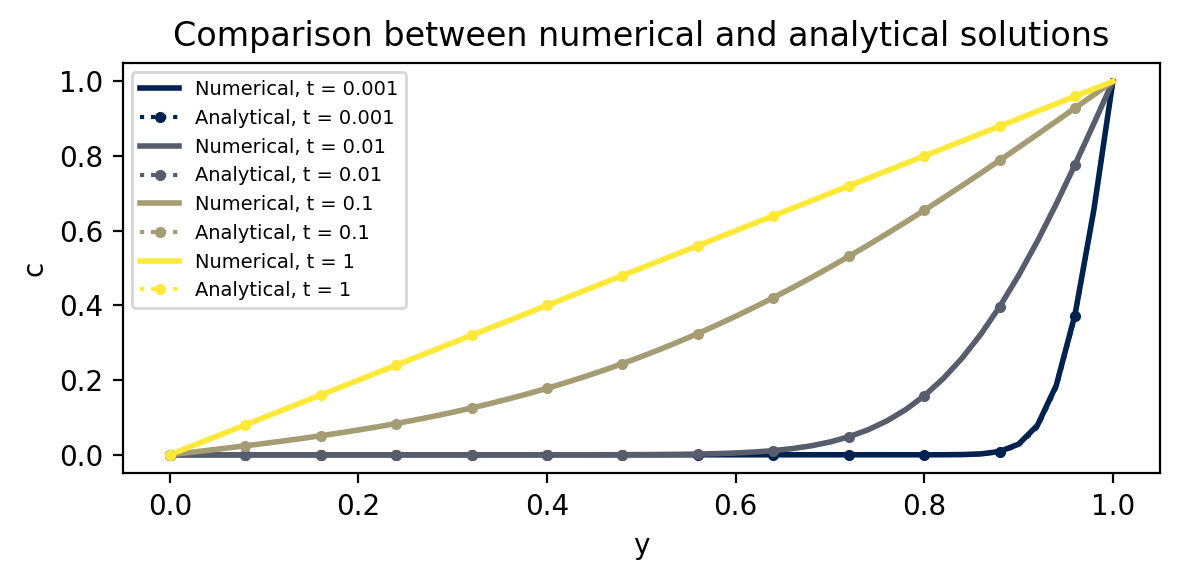

In [15]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=200)

colors = plt.cm.cividis(np.linspace(0, 1, len(times)))

for k, t in enumerate(times):
    n = int(np.round(t / dt))
    Cn = solution[n]

    c_num = Cn[:, x_index]
    c_exact = analytical_solution_y(y, t, D)

    # Numerical solution (solid line)
    ax.plot(
        y,
        c_num,
        color=colors[k],
        linestyle='-',
        linewidth=2,
        label=f"Numerical, t = {t:g}"
    )

    # Analytical solution (dashed line + points)
    ax.plot(
        y,
        c_exact,
        color=colors[k],
        linestyle=':',
        marker='o',
        markersize=3,
        markevery=4,
        linewidth=1.5,
        label=f"Analytical, t = {t:g}"
    )

ax.set_xlabel("y")
ax.set_ylabel("c")
ax.set_title("Comparison between numerical and analytical solutions")
ax.legend(fontsize=7)
plt.tight_layout()

plt.savefig("outputs/E_analytical_comparison.png", dpi=200)
plt.show()
plt.close(fig)

# Question F

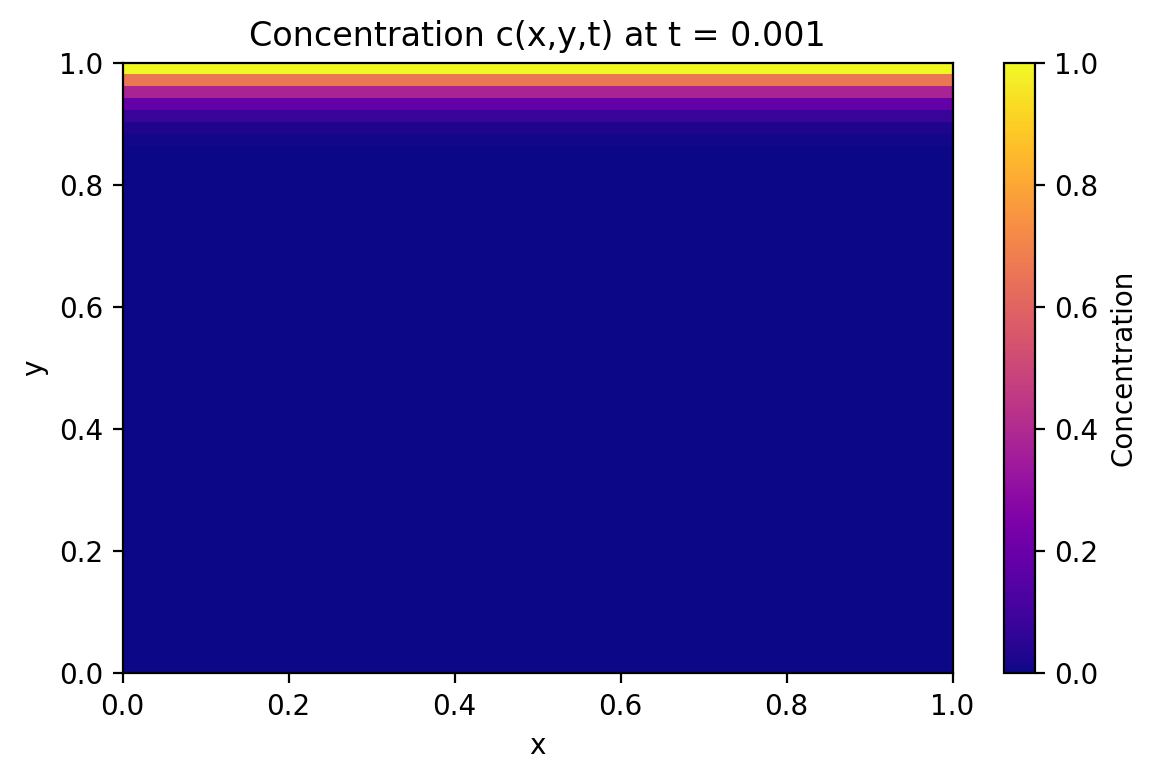

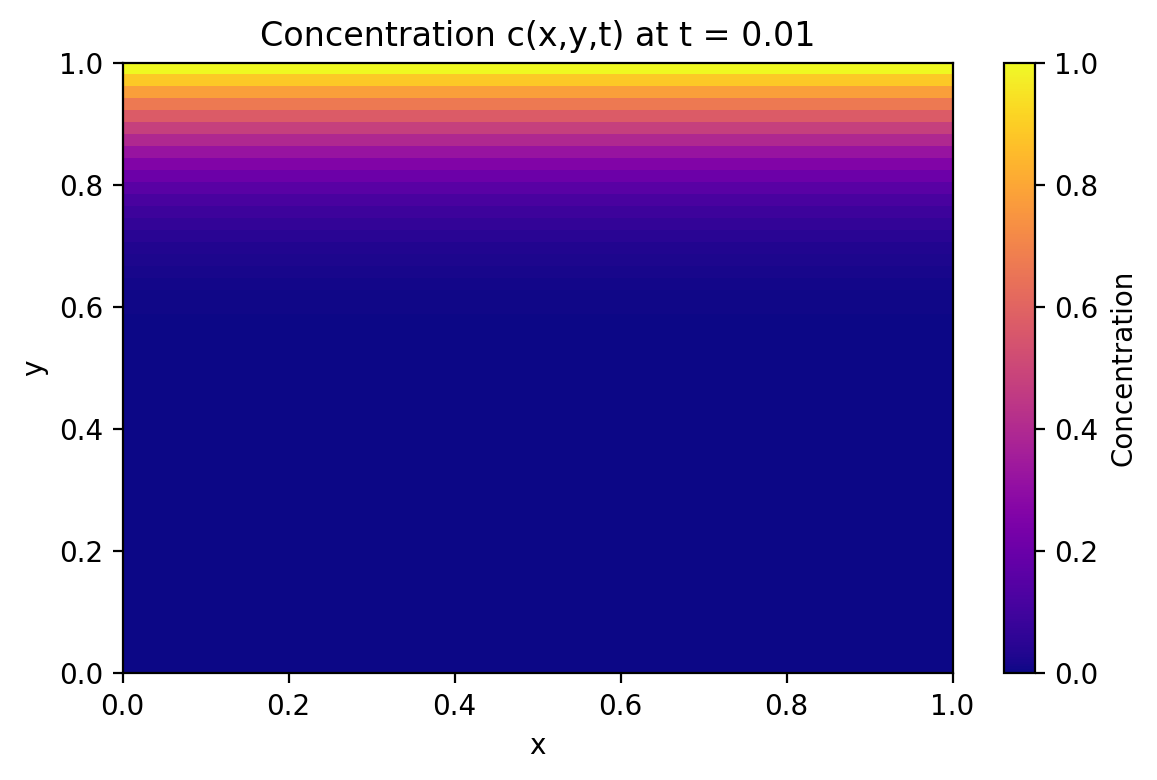

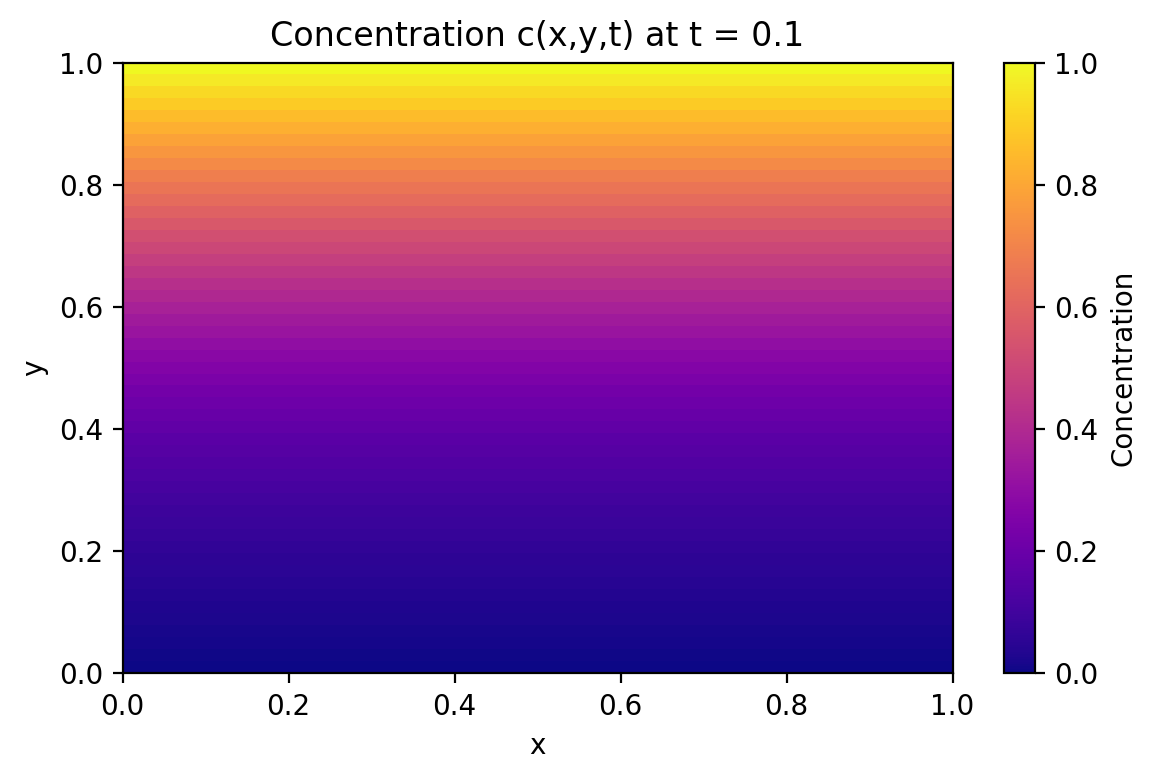

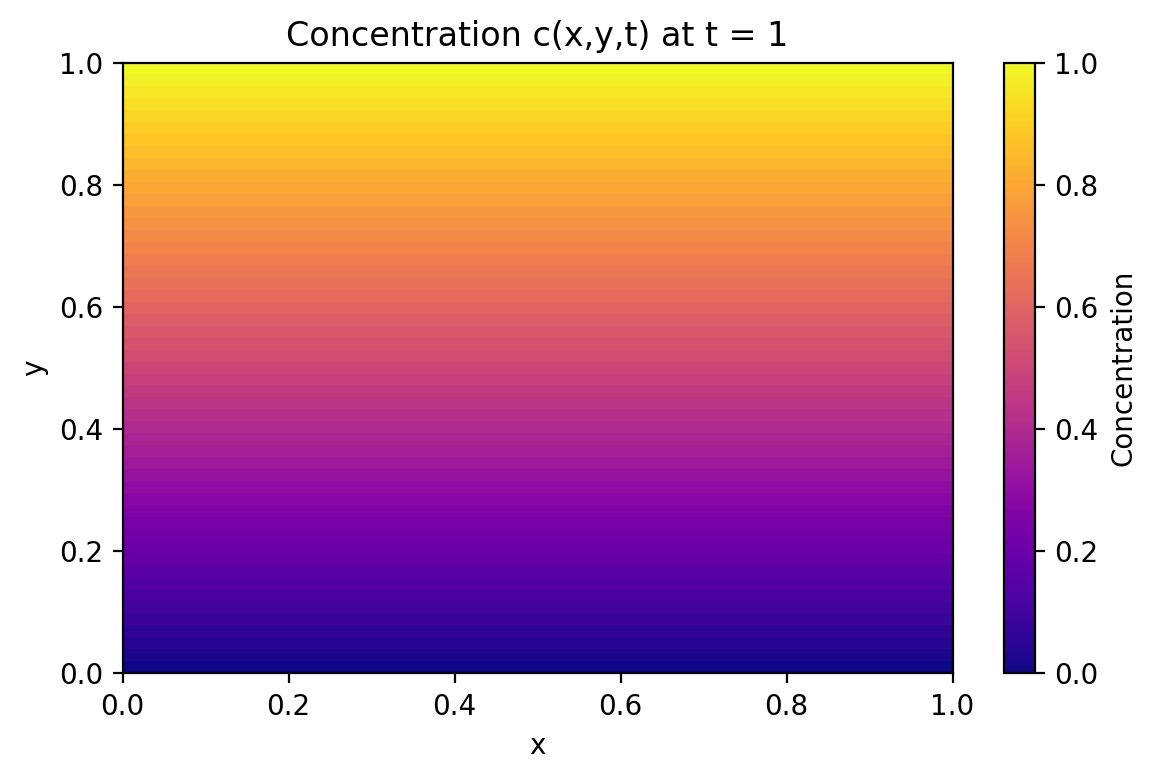

In [31]:
for t in times:
    n = int(np.round(t / dt))
    Cn = solution[n]
    plot_figure_2d(
        Cn,
        title=f"Concentration c(x,y,t) at t = {t:g}",
        output_file=f"outputs/F_2d_domain_t{t:g}.png",
        show=True
    )